In [29]:
import os
import pyproj
import geopandas as gpd
os.environ['PROJ_LIB'] = os.path.join(pyproj.datadir.get_data_dir(), 'proj')


transect_gdf = gpd.read_file('/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/transect.gpkg')
transect_gdf = transect_gdf.to_crs(epsg=3035)

transect = transect_gdf.geometry.iloc[0]


In [30]:
import rasterio
from rasterio.sample import sample_gen
import numpy as np

def sample_along_transect(raster_path, transect_line, num_points=1000):
    transect_length_km = transect_line.length / 1000  # Assuming CRS is in meters, convert to kilometers
    with rasterio.open(raster_path) as src:
        coords = [(transect_line.interpolate(float(i) / num_points, normalized=True).x, 
                   transect_line.interpolate(float(i) / num_points, normalized=True).y) 
                  for i in range(num_points + 1)]
        values = list(src.sample(coords))
    return np.array(values), np.linspace(0, transect_length_km, num_points + 1)


In [40]:
maps = ['http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_m_30m_b0cm..20cm_20200101_20221231_eu_epsg.3035_v20240804.tif',
 'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p025_30m_b0cm..20cm_20200101_20221231_eu_epsg.3035_v20240804.tif',
 'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p975_30m_b0cm..20cm_20200101_20221231_eu_epsg.3035_v20240804.tif']

mean, distance = sample_along_transect(maps[0], transect)
p025, _ = sample_along_transect(maps[1], transect)
p975, _ = sample_along_transect(maps[2], transect)

mean = np.where(mean == 32767, np.nan, mean)
p025 = np.where(p025 == 32767, np.nan, p025)
p975 = np.where(p975 == 32767, np.nan, p975)

mean = mean.flatten()
p025 = p025.flatten()
p975 = p975.flatten()
distance = distance.flatten()

mask = ~np.isnan(mean) & ~np.isnan(p025) & ~np.isnan(p975)

mean = mean[mask]
p025 = p025[mask]
p975 = p975[mask]
distance = distance[mask] 



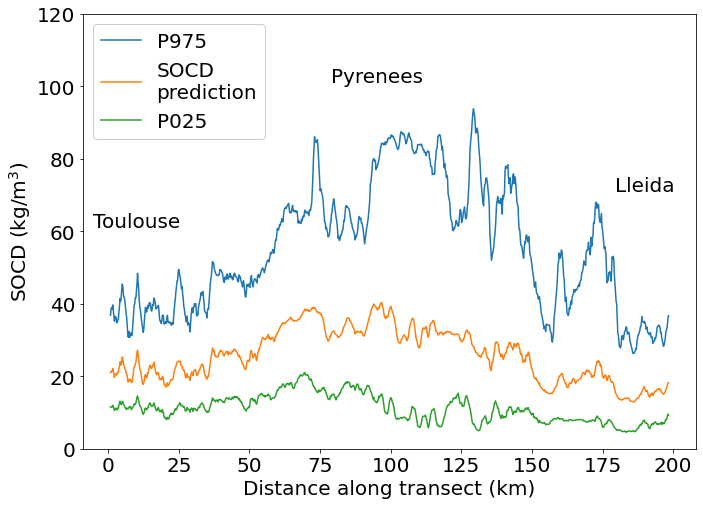

In [78]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set the window size (adjust as needed)
window_size = 10

# Apply moving average to smooth the lines
mean_smoothed = moving_average(mean, window_size)
p025_smoothed = moving_average(p025, window_size)
p975_smoothed = moving_average(p975, window_size)

# Adjust the distance array to match the length of the smoothed arrays
distance_smoothed = distance[(window_size - 1)//2 : -(window_size - 1)//2 or None]


import matplotlib.pyplot as plt

plt.figure(figsize=(11, 8))
plt.plot(distance_smoothed, p975_smoothed/10, label='P975')
plt.plot(distance_smoothed, mean_smoothed/10, label='SOCD\nprediction')
plt.plot(distance_smoothed, p025_smoothed/10, label='P025')

# Set font sizes
plt.xlabel('Distance along transect (km)', fontsize=20)
plt.ylabel('SOCD (kg/m$^3$)', fontsize=20)
# plt.title('The Transect', fontsize=20)
plt.ylim([0, 120])

# Set legend font size
plt.legend(fontsize=20, loc = 'upper left', framealpha=1)

# Set tick font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adding text annotations at specific points
# You should determine the exact coordinates based on your data. 
# These coordinates are just placeholders and need to be adjusted.

# Toulouse
plt.text(x=10, y=60, s="Toulouse", fontsize=20, ha='center', va='bottom')

# Lleida
plt.text(x=190, y=70, s="Lleida", fontsize=20, ha='center', va='bottom')

# Bilinius Mountain
plt.text(x=95, y=100, s="Pyrenees", fontsize=20, ha='center', va='bottom')

plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_transect.pdf', dpi=300, format='pdf')
plt.show()